In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

import argparse
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_sparse import SparseTensor
from torch_geometric.utils import to_undirected, dropout_adj
import os
import os.path as osp

from ogb.nodeproppred import PygNodePropPredDataset

import torch
from torch_geometric.data import Data

import os.path as osp
from sklearn import preprocessing

## Загрузка данных

In [81]:
data = pd.read_csv('./Data/2_full_table_data_GNN.csv')

In [82]:
data.shape

(115525128, 14)

In [83]:
data

,date_key,amount,client_inn,partner_inn,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,Fraud_presence,Reject_presence
0,2018-03-01,41000.00,1279230,1,54.0,6251.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2018-03-01,482300.00,1224261,13022,40.0,1618.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2018-03-01,15.72,1549773,119556,52.0,7370.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2018-03-01,4217742.30,976651,976651,51.0,2103.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2018-03-01,11.77,1413113,1003953,41.0,526.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115525123,2021-03-01,885.61,1739204,656965,37.0,3182.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
115525124,2021-03-01,127165.00,426567,1796124,35.0,3592.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
115525125,2021-03-01,136920.00,1070950,1736097,51.0,3466.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
115525126,2021-03-01,6.00,1387950,119556,47.0,2519.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Нужно ли убирать в данных для x client_inn и partner_inn???

In [43]:
data_with_inn = data

In [44]:
#data = data.drop(['client_inn', 'partner_inn'], axis=1)

In [45]:
data

,date_key,amount,client_inn,partner_inn,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,Fraud_presence,Reject_presence
0,2018-03-01,41000.00,1279230,1,54.0,6251.0,1,0,0,0,0,1,0.0,0.0
1,2018-03-01,618280.00,1279230,1003953,54.0,6251.0,1,0,0,0,0,1,0.0,0.0
2,2018-03-01,2698540.00,1279230,682959,54.0,6251.0,1,0,0,0,0,1,0.0,0.0
3,2018-03-01,3000.00,1279230,1852820,54.0,6251.0,1,0,0,0,0,1,0.0,0.0
4,2018-03-01,1000.00,1279230,119556,54.0,6251.0,1,0,0,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7015932,2021-03-01,1000.00,673145,1003953,47.0,127.0,0,0,1,0,0,1,0.0,0.0
7015933,2021-03-01,290.00,764479,119556,46.0,375.0,0,0,1,0,0,1,0.0,1.0
7015934,2021-03-01,2000.00,398315,119556,34.0,126.0,0,1,0,0,0,1,0.0,0.0
7015935,2021-03-01,10855.68,1095817,1095817,42.0,187.0,0,0,1,0,1,0,0.0,0.0


In [46]:
data.shape

(7015937, 14)

In [47]:
#data_with_inn.drop_duplicates(subset=['client_inn'])

## Перевод исходного датасета в датасет для графов

In [86]:
features_dataset = data.drop(['Fraud_presence', 'date_key'], axis=1)

In [6]:
features_dataset

,amount,client_inn,partner_inn,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,Reject_presence
0,41000.00,1279230,1,54.0,6251.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,482300.00,1224261,13022,40.0,1618.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,15.72,1549773,119556,52.0,7370.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4217742.30,976651,976651,51.0,2103.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,11.77,1413113,1003953,41.0,526.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115525123,885.61,1739204,656965,37.0,3182.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
115525124,127165.00,426567,1796124,35.0,3592.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
115525125,136920.00,1070950,1736097,51.0,3466.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
115525126,6.00,1387950,119556,47.0,2519.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
features_dataset.shape

(115525128, 12)

## Label encoding для client_inn и partner_inn

In [87]:
#Выделяем два столбца: client_inn и partner_inn
client_inn_columnn = features_dataset['client_inn']
partner_inn_columnn = features_dataset['partner_inn']

In [88]:
#Объединяем их один под другим, чтобы получился один столбец
inn_cl_par = pd.concat([client_inn_columnn, partner_inn_columnn], axis=0)
inn_cl_par

0            1279230
1            1224261
2            1549773
3             976651
4            1413113
              ...   
115525123     656965
115525124    1796124
115525125    1736097
115525126     119556
115525127     503750
Length: 231050256, dtype: int64

In [89]:
#Удаляем дубликаты
inn_cl_par = inn_cl_par.drop_duplicates()
inn_cl_par

0            1279230
1            1224261
2            1549773
3             976651
4            1413113
              ...   
115524744    1245863
115524794    1150926
115524795    1599973
115525041    1742304
115525112     782074
Length: 1537517, dtype: int64

In [11]:
#Создаем label encoder на объединенных client_inn и partner_inn
encoder = preprocessing.LabelEncoder()
encoder.fit(inn_cl_par)

LabelEncoder()

In [12]:
#Кодируем и столбец client_inn и столбец partner_inn при помощи Label encoder
features_dataset['new_client_inn'] = encoder.transform(features_dataset['client_inn'])

In [13]:
features_dataset['new_partner_inn'] = encoder.transform(features_dataset['partner_inn'])

In [14]:
features_dataset

,amount,client_inn,partner_inn,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,Reject_presence,new_client_inn,new_partner_inn
0,41000.00,1279230,1,54.0,6251.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1025066,0
1,482300.00,1224261,13022,40.0,1618.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,982241,10323
2,15.72,1549773,119556,52.0,7370.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1242692,95545
3,4217742.30,976651,976651,51.0,2103.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,786977,786977
4,11.77,1413113,1003953,41.0,526.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1129533,808404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115525123,885.61,1739204,656965,37.0,3182.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1391164,530732
115525124,127165.00,426567,1796124,35.0,3592.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,339497,1437180
115525125,136920.00,1070950,1736097,51.0,3466.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,863351,1388607
115525126,6.00,1387950,119556,47.0,2519.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1108693,95545


In [15]:
features_dataset = features_dataset.drop(['client_inn', 'partner_inn'], axis=1)

In [16]:
features_dataset

,amount,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,Reject_presence,new_client_inn,new_partner_inn
0,41000.00,54.0,6251.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1025066,0
1,482300.00,40.0,1618.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,982241,10323
2,15.72,52.0,7370.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1242692,95545
3,4217742.30,51.0,2103.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,786977,786977
4,11.77,41.0,526.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1129533,808404
...,...,...,...,...,...,...,...,...,...,...,...,...
115525123,885.61,37.0,3182.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1391164,530732
115525124,127165.00,35.0,3592.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,339497,1437180
115525125,136920.00,51.0,3466.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,863351,1388607
115525126,6.00,47.0,2519.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1108693,95545


In [17]:
x = torch.tensor(features_dataset.drop(['new_client_inn', 'new_partner_inn'], axis=1).values.astype(np.float32)) 

In [18]:
y = torch.tensor(data['Fraud_presence'].values.astype(np.float32))

In [19]:
edge_index = features_dataset[['new_client_inn', 'new_partner_inn']].values.T
edge_index = torch.tensor(edge_index).to(dtype=torch.long)

In [20]:
edge_index

tensor([[1025066,  982241, 1242692,  ...,  863351, 1108693,  609031],
        [      0,   10323,   95545,  ..., 1388607,   95545,  403960]])

In [45]:
edge_index_data=edge_index

In [21]:
#Перевод данных в датасет для графа
data_graph = Data(x=x, y=y, edge_index=edge_index)

In [22]:
data_graph

Data(x=[115525128, 10], edge_index=[2, 115525128], y=[115525128])

In [23]:
x = data_graph.x
N = data_graph.num_nodes

In [24]:
print(N)

115525128


In [25]:
data_graph.edge_index

tensor([[1025066,  982241, 1242692,  ...,  863351, 1108693,  609031],
        [      0,   10323,   95545,  ..., 1388607,   95545,  403960]])

In [26]:
data_graph.edge_index.shape

torch.Size([2, 115525128])

In [27]:
path = './adj_gcn.pt'
print('Making the graph undirected.')

data_graph.edge_index, _ = dropout_adj(
       data_graph.edge_index, p=0, num_nodes=data_graph.num_nodes)

data_graph.edge_index

Making the graph undirected.


/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


tensor([[1025066,  982241, 1242692,  ...,  863351, 1108693,  609031],
        [      0,   10323,   95545,  ..., 1388607,   95545,  403960]])

In [28]:
data_graph

Data(x=[115525128, 10], edge_index=[2, 115525128], y=[115525128])

In [29]:
data_graph.num_nodes

115525128

In [30]:
data_graph.edge_index.shape

torch.Size([2, 115525128])

In [31]:
data_graph.edge_index = to_undirected(data_graph.edge_index, num_nodes=data_graph.num_nodes)

In [32]:
print(data_graph.edge_index)

tensor([[      0,       0,       0,  ..., 1537514, 1537515, 1537516],
        [      0,      79,      91,  ..., 1158724,  998194, 1195941]])


In [33]:
type(data_graph.edge_index)

torch.Tensor

In [34]:
torch.max(data_graph.edge_index)

tensor(1537516)

In [35]:
row, col = data_graph.edge_index
print('Computing adj...')

adj = SparseTensor(row=row, col=col, sparse_sizes=(N, N))
adj = adj.set_diag()
deg = adj.sum(dim=1).to(torch.float)
deg_inv_sqrt = deg.pow(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
adj = deg_inv_sqrt.view(-1, 1) * adj * deg_inv_sqrt.view(1, -1)
adj = adj.to_scipy(layout='csr')

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
adj=sparse_mx_to_torch_sparse_tensor(adj)
print('Start processing')

Computing adj...
Start processing


In [38]:
num_hops = 3
#saved = torch.cat((x[train_idx], x[valid_idx], x[test_idx]), dim=0)
torch.save(data_graph, f'./2_graph.pt')

for i in tqdm(range(num_hops)):
    x = adj @ x
    torch.save(x, f'./2_graph_hope_{i+1}.pt')

100%|██████████| 3/3 [01:27<00:00, 29.07s/it]


# Node2Vec

## Получаем вложения узлов

In [50]:
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
#from torch_geometric.typing import WITH_TORCH_CLUSTER

#if not WITH_TORCH_CLUSTER:
#    quit("This example requires 'torch-cluster'")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

data = data_graph
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)

num_workers = 0 if sys.platform.startswith('win') else 4
loader = model.loader(batch_size=128, shuffle=True,
                       num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:

'''
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc
'''

for epoch in range(1, 2):
    loss = train()
    #acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}') #Acc: {acc:.4f}

In [69]:
z = model()
# from tensor to numpy
node_embed = z.detach().numpy()
node_embed

array([[-0.37166297, -0.06175916,  0.135627  , ...,  0.28544357,
        -0.00251235, -0.27991998],
       [-0.2757652 , -0.05490542, -0.112152  , ..., -0.23549333,
        -0.04327112,  0.1376911 ],
       [ 0.23542663, -0.05401051, -0.10948652, ...,  0.3027083 ,
        -0.24643229, -0.28221577],
       ...,
       [ 0.1818186 ,  0.04764168, -0.08961472, ...,  0.04131594,
         0.01805175, -0.21118404],
       [ 0.16377681,  0.17492904,  0.01542295, ...,  0.2399571 ,
         0.14312366, -0.14500217],
       [-0.09930721,  0.1342981 , -0.43279943, ...,  0.11152011,
         0.03955721,  0.08421714]], dtype=float32)

In [70]:
#from numpy to dataframe
node_embed_df = pd.DataFrame(node_embed)
node_embed_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.371663,-0.061759,0.135627,0.290071,0.038293,0.555338,-0.734200,-0.439418,0.822504,0.027101,...,-0.418924,0.068128,-0.874551,0.561187,0.141047,-0.508170,-0.079400,0.285444,-0.002512,-0.279920
1,-0.275765,-0.054905,-0.112152,0.231291,-0.075648,0.094263,-0.056846,0.088675,0.024605,0.338420,...,-0.246591,0.154508,0.016068,-0.066637,0.058423,0.103790,0.144651,-0.235493,-0.043271,0.137691
2,0.235427,-0.054011,-0.109487,0.355568,-0.142746,-0.291352,-0.115349,0.038127,0.240170,-0.219413,...,0.074253,-0.553019,-0.000067,0.063700,0.114580,-0.125138,0.016804,0.302708,-0.246432,-0.282216
3,-0.262765,-0.175118,0.120543,0.110506,-0.270543,0.024122,0.115574,-0.174833,0.171613,0.190261,...,-0.111852,0.131530,-0.028107,-0.129749,0.171794,-0.054726,0.087309,-0.004686,-0.337389,0.237552
4,0.181947,-0.163054,0.047006,0.393082,-0.097658,-0.039602,-0.023393,0.170114,0.140793,-0.292391,...,0.007329,-0.121699,0.092036,-0.144761,-0.273190,-0.004198,0.198166,-0.123489,0.065426,0.135733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537512,0.330583,-0.062632,-0.065933,0.013566,-0.080241,0.292679,-0.221218,-0.093435,0.211906,-0.269273,...,-0.033244,0.049834,-0.071149,-0.009641,-0.037774,-0.165929,-0.196504,0.331562,0.159364,0.017219
1537513,0.183067,-0.027665,0.163328,-0.028286,0.268492,0.132101,-0.153324,-0.188644,-0.156056,-0.152176,...,0.058739,0.200161,0.157407,-0.269300,-0.072910,0.063440,-0.074368,-0.456967,0.114594,-0.268420
1537514,0.181819,0.047642,-0.089615,-0.210192,-0.017346,-0.087344,-0.094396,0.104560,-0.083605,0.307751,...,-0.212748,0.105838,0.163370,-0.122125,-0.313587,0.064382,0.104574,0.041316,0.018052,-0.211184
1537515,0.163777,0.174929,0.015423,0.008481,0.331031,-0.067500,0.096243,0.107028,-0.108222,-0.125329,...,-0.070202,-0.074491,0.101539,-0.031452,-0.099863,-0.041110,0.000785,0.239957,0.143124,-0.145002


In [112]:
inn_cl_par_df = pd.DataFrame(inn_cl_par, columns=['client_inn'])
inn_cl_par_df

,client_inn
0,1279230
1,1224261
2,1549773
3,976651
4,1413113
...,...
115524744,1245863
115524794,1150926
115524795,1599973
115525041,1742304


In [114]:
inn_cl_par_df.client_inn.nunique()

1537517

In [115]:
inn_cl_par_df_reset = inn_cl_par_df.reset_index(drop=True)
inn_cl_par_df_reset

,client_inn
0,1279230
1,1224261
2,1549773
3,976651
4,1413113
...,...
1537512,1245863
1537513,1150926
1537514,1599973
1537515,1742304


In [116]:
#Объединяем полученный датасет со всеми инн клиентов и партнеров вместе, чтобы т.о. получить инн строк
node_embed_df_with_inn = pd.concat([inn_cl_par_df_reset, node_embed_df], axis=1)
node_embed_df_with_inn

,client_inn,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,1279230,-0.371663,-0.061759,0.135627,0.290071,0.038293,0.555338,-0.734200,-0.439418,0.822504,...,-0.418924,0.068128,-0.874551,0.561187,0.141047,-0.508170,-0.079400,0.285444,-0.002512,-0.279920
1,1224261,-0.275765,-0.054905,-0.112152,0.231291,-0.075648,0.094263,-0.056846,0.088675,0.024605,...,-0.246591,0.154508,0.016068,-0.066637,0.058423,0.103790,0.144651,-0.235493,-0.043271,0.137691
2,1549773,0.235427,-0.054011,-0.109487,0.355568,-0.142746,-0.291352,-0.115349,0.038127,0.240170,...,0.074253,-0.553019,-0.000067,0.063700,0.114580,-0.125138,0.016804,0.302708,-0.246432,-0.282216
3,976651,-0.262765,-0.175118,0.120543,0.110506,-0.270543,0.024122,0.115574,-0.174833,0.171613,...,-0.111852,0.131530,-0.028107,-0.129749,0.171794,-0.054726,0.087309,-0.004686,-0.337389,0.237552
4,1413113,0.181947,-0.163054,0.047006,0.393082,-0.097658,-0.039602,-0.023393,0.170114,0.140793,...,0.007329,-0.121699,0.092036,-0.144761,-0.273190,-0.004198,0.198166,-0.123489,0.065426,0.135733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537512,1245863,0.330583,-0.062632,-0.065933,0.013566,-0.080241,0.292679,-0.221218,-0.093435,0.211906,...,-0.033244,0.049834,-0.071149,-0.009641,-0.037774,-0.165929,-0.196504,0.331562,0.159364,0.017219
1537513,1150926,0.183067,-0.027665,0.163328,-0.028286,0.268492,0.132101,-0.153324,-0.188644,-0.156056,...,0.058739,0.200161,0.157407,-0.269300,-0.072910,0.063440,-0.074368,-0.456967,0.114594,-0.268420
1537514,1599973,0.181819,0.047642,-0.089615,-0.210192,-0.017346,-0.087344,-0.094396,0.104560,-0.083605,...,-0.212748,0.105838,0.163370,-0.122125,-0.313587,0.064382,0.104574,0.041316,0.018052,-0.211184
1537515,1742304,0.163777,0.174929,0.015423,0.008481,0.331031,-0.067500,0.096243,0.107028,-0.108222,...,-0.070202,-0.074491,0.101539,-0.031452,-0.099863,-0.041110,0.000785,0.239957,0.143124,-0.145002


In [67]:
data_agg_data = pd.read_csv('./Data/2_agg_final_data.csv')
data_agg_data

,"('amount', 'mean')",client_inn,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,Fraud_presence,Reject_presence
0,9.948950e+05,1,44.0,4886.0,0,0,1,0,0,1,0.0,0.0
1,6.072894e+03,94,39.0,1510.0,1,0,0,0,0,1,0.0,0.0
2,2.787111e+05,114,60.0,2826.0,1,0,0,0,0,1,0.0,0.0
3,5.241910e+05,129,44.0,5479.0,1,0,0,0,1,0,0.0,0.0
4,4.365950e+04,166,32.0,608.0,0,0,1,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63859,2.565470e+04,1920916,47.0,3463.0,0,0,1,0,0,1,0.0,0.0
63860,1.027485e+06,1920997,53.0,3429.0,1,0,0,0,1,0,0.0,0.0
63861,4.958946e+04,1921028,30.0,2806.0,0,0,1,0,0,1,0.0,0.0
63862,9.089023e+04,1921064,33.0,3457.0,0,1,0,0,0,1,0.0,0.0


In [118]:
#merge left - к строкам датасета левого добавляются строки правого. То есть размерность левого датасета
data_with_embed = data_agg_data.merge(node_embed_df_with_inn, on='client_inn', how='left')
data_with_embed

,"('amount', 'mean')",client_inn,years,Длина_Отн_в_днях,Клиент_Сегмент_КБ,Клиент_Сегмент_МБ,Клиент_Сегмент_МКП,Клиент_Сегмент_СБ,Клиент_НаличиеЗПпроекта_Д,Клиент_НаличиеЗПпроекта_Н,...,118,119,120,121,122,123,124,125,126,127
0,9.948950e+05,1,44.0,4886.0,0,0,1,0,0,1,...,-0.055616,-0.031330,0.333460,-0.159244,-0.125699,-0.125951,0.096059,-0.050496,0.111755,-0.180697
1,6.072894e+03,94,39.0,1510.0,1,0,0,0,0,1,...,0.123769,-0.113315,-0.018651,-0.199680,-0.217345,-0.178476,-0.011291,-0.026019,0.067973,-0.108155
2,2.787111e+05,114,60.0,2826.0,1,0,0,0,0,1,...,-0.162971,-0.038067,0.240530,0.074382,-0.005759,0.165980,-0.090568,-0.160132,-0.061440,-0.039264
3,5.241910e+05,129,44.0,5479.0,1,0,0,0,1,0,...,-0.024113,-0.061977,-0.207906,-0.010041,0.055161,0.134499,-0.106176,0.163848,0.036398,0.088827
4,4.365950e+04,166,32.0,608.0,0,0,1,0,0,1,...,0.214098,-0.019054,0.167464,-0.044606,-0.101938,-0.008328,-0.000864,0.014873,-0.233270,-0.237960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63859,2.565470e+04,1920916,47.0,3463.0,0,0,1,0,0,1,...,-0.314689,0.114682,0.007360,-0.109657,-0.080042,0.067397,-0.068557,-0.025029,-0.012714,0.266205
63860,1.027485e+06,1920997,53.0,3429.0,1,0,0,0,1,0,...,-0.171834,-0.245547,0.282288,-0.176632,0.156378,0.103908,-0.030265,0.136169,-0.105718,-0.061316
63861,4.958946e+04,1921028,30.0,2806.0,0,0,1,0,0,1,...,-0.041418,-0.166489,0.013427,-0.065626,-0.182247,0.086192,-0.004886,-0.142943,0.291969,0.256306
63862,9.089023e+04,1921064,33.0,3457.0,0,1,0,0,0,1,...,0.141524,-0.355139,0.111953,0.108110,0.289029,0.295166,0.020001,0.291933,-0.056418,0.169866


In [119]:
#Сохраняем таблицу с данными по клиентам после groupby и aggr + эмбединги вершин
data_with_embed.to_csv('./Data/2_agg_final_data_embed.csv', index=False)

# Random Forest

In [120]:
from sklearn.model_selection import  learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.model_selection import  learning_curve
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss

import torch
from torch_geometric.data import Data

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, roc_auc_score, roc_curve

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

In [121]:
data_X = data_with_embed.drop(['Fraud_presence', 'Reject_presence', 'client_inn'], axis=1)

In [122]:
data_Y = data_with_embed[['Fraud_presence']]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)

In [124]:
X_train.isna().sum()

('amount', 'mean')    0
years                 0
Длина_Отн_в_днях      0
Клиент_Сегмент_КБ     0
Клиент_Сегмент_МБ     0
                     ..
123                   0
124                   0
125                   0
126                   0
127                   0
Length: 137, dtype: int64

In [125]:
rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

In [136]:
param_grid = {
    'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_estimators': [10,20,30,40,50,60,70,80,90,100]
}

In [137]:
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
CV_rfc.fit(X_train, y_train)

/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtype

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]})

In [138]:
CV_rfc.best_params_

{'max_depth': 19, 'n_estimators': 80}

In [139]:
rf_best_param=RandomForestClassifier(random_state = 1, max_depth=19, n_estimators=80, n_jobs=-1)

In [140]:
rf_best_param.fit(X_train, y_train)

/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/tmp/ipykernel_2563563/3673881811.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_best_param.fit(X_train, y_train)


RandomForestClassifier(max_depth=19, n_estimators=80, n_jobs=-1, random_state=1)

In [141]:
predictions_rf = rf_best_param.predict(X_test)
predictions_rf

/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([0., 0., 0., ..., 0., 0., 0.])

In [142]:
print("Precision:", precision_score(y_test, predictions_rf))
print("Recall: ", recall_score(y_test, predictions_rf))
print("Accuracy: ", accuracy_score(y_test, predictions_rf))
print("F1-score: ", f1_score(y_test, predictions_rf))
print("Log_loss: ", log_loss(y_test, predictions_rf))

Precision: 0.7854406130268199
Recall:  0.19873969946679593
Accuracy:  0.9162554564433479
F1-score:  0.31721470019342357
Log_loss:  2.892438313338847


In [143]:
roc_auc_score(y_test, rf_best_param.predict_proba(X_test)[:,1])

/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8939663422370984

In [144]:
predict = rf_best_param.predict_proba(X_test)
pos_param = predict[:, 1]

/data/home/krazheva/.conda/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


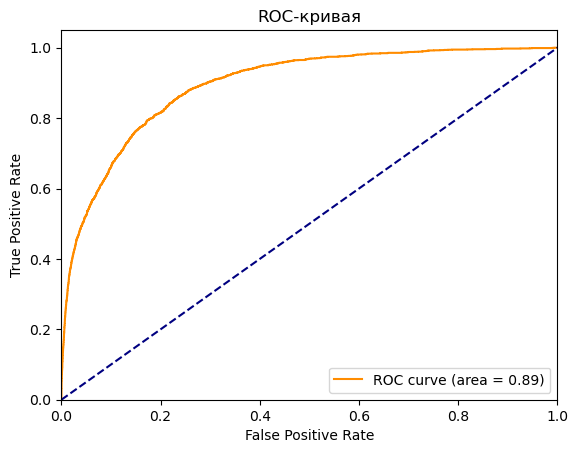

In [145]:
fpr, tpr, treshold = roc_curve(y_test, pos_param)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()